In [1]:
# !git clone https://github.com/NNgocCongAnh/Project_Dep.git

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from model_scratch import *

In [3]:
train_data=pd.read_csv('sign_mnist_train.csv')
test_data=pd.read_csv('sign_mnist_test.csv')

In [4]:
X_train=train_data.drop('label',axis=1).values
y_train=train_data['label'].values
X_test=test_data.drop('label',axis=1).values
y_test=test_data['label'].values

In [5]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((27455, 784), (27455,), (7172, 784), (7172,))

In [6]:
X_train_max=np.max(X_train, axis=1,keepdims=True)
X_train_min=np.min(X_train, axis=1,keepdims=True)
X_train1=(X_train-X_train_min)/(X_train_max-X_train_min)
X_test_max=np.max(X_test, axis=1,keepdims=True)
X_test_min=np.min(X_test, axis=1,keepdims=True)
X_test1=(X_test-X_test_min)/(X_test_max-X_test_min)

In [7]:
X_train1.shape,X_test1.shape

((27455, 784), (7172, 784))

In [8]:
X_train1[0][0],X_test1[0][0]

(0.3939393939393939, 0.765625)

In [9]:
o_y_train=pd.get_dummies(y_train)
o_y_test=pd.get_dummies(y_test)

In [10]:
y_train1=o_y_train.astype('int')
y_test1=o_y_test.astype('int')

In [11]:
y_train1.shape,y_test1.shape

((27455, 24), (7172, 24))

In [12]:
X_train2=X_train1.reshape(-1,28,28,1)
X_test2=X_test1.reshape(-1,28,28,1)

In [13]:
class ConVLayers:
    def __init__(self,layers):
        self.layers=layers

    def forward(self,X):  # Fixed method signature
        cache=[self.layers[0].forward(X)]
        l=0
        for i in range(1,len(self.layers)):
            cache.append(self.layers[i].forward(cache[l][0]))
            l+=1
        return cache

    def backward(self,dZ,Y,cache):  # Fixed method signature
        for l in reversed(range(len(self.layers))):
            dZ = self.layers[l].backward(dZ, cache[l][1])
        return dZ

class Conv2D:
    def __init__(self,input_size,f,n_C,lr,stride=1):
        (m,H_prev,W_prev,n_C_prev)=input_size
        pad=(f-1)//2
        self.lr=lr
        (self.W,self.b)=initialize_conv_parameters(f,n_C_prev,n_C)
        self.params={'stride':stride,'pad':pad}

    def forward(self,A_prev):
        return conv_forward(A_prev,self.W,self.b,self.params)

    def backward(self,dZ,cache):
        dA_prev, dW, db = conv_backward(dZ,cache)
        # Update weights and biases
        self.W -= self.lr*dW
        self.b -= self.lr*db
        return dA_prev

class MaxPool2D:
    def __init__(self,f,stride):
        self.params={'f':f,'stride':stride}
    def forward(self,A_prev):
        return pool_forward(A_prev,self.params)
    def backward(self,dA,cache):
        return pool_backward(dA,cache)

class Dense:
    def __init__(self,layer_dims):
        self.params=initialize_parameters_deep(layer_dims)
    def forward(self,X):
        return L_model_forward(X,self.params)
    def backward(self,AL,Y,caches):
        return L_model_backward(AL,Y,caches)
    def update(self,grads,learning_rate):
        self.params= update_parameters(self.params,grads,learning_rate)
class CNN:
    def __init__(self,conv,dense):
        self.conv=conv
        self.dense=dense
    def forward(self,X):
        c=self.conv.forward(X)
        c1=c[-1][0].reshape(-1,X.shape[0])
        p=self.dense.forward(c1)
        return c,p
    def print_cost(self,p,Y):
        cost=compute_cost(p[0],Y)
        print(cost)
        return cost
    def backward(self,p,Y,c,lr):
        shape=c[-1][0].shape
        dZ=p[0].reshape(-1,p[0].shape[1])
        x=self.dense.backward(dZ,Y,p[1])
        dA=x['dA0']
        self.dense.update(x,lr)
        dA=dA.reshape(shape)
        self.conv.backward(dA,Y,c)
a = [
    Conv2D((5,28,28,1), 3, 32, 0.01),
    MaxPool2D(2, 2),
    Conv2D((5,14,14,32), 3, 64, 0.01),
    MaxPool2D(2, 2),
    Conv2D((5,7,7,64), 3, 64, 0.01),
    MaxPool2D(2, 2),
]
conv=ConVLayers(a)
dens=Dense([1024,24])
cnn=CNN(conv,dens)

In [14]:
print("Dense Layer:")
print(f"  - Layer Dimensions: {dens.params.keys()}")  # In danh sách các tham số
for key in dens.params:
    print(f"  - {key} shape: {dens.params[key].shape}")

Dense Layer:
  - Layer Dimensions: dict_keys(['W1', 'b1'])
  - W1 shape: (24, 1024)
  - b1 shape: (24, 1)


In [15]:
X_test.shape

(7172, 784)

In [16]:
X_test = np.random.randn(1024, 5)  # Batch size = 5
dense_out = dens.forward(X_test)

print("Dense Output Shape:", dense_out[0].shape)  # Kiểm tra kích thước đầu ra

Dense Output Shape: (24, 5)


In [17]:
for i, layer in enumerate(a):
    print(f"Layer {i+1}: {type(layer).__name__}")

    if isinstance(layer, Conv2D):
        print(f"  - Type: Convolutional Layer")
        print(f"  - Kernel Size: {layer.W.shape}")
        print(f"  - Bias Shape: {layer.b.shape}")
        print(f"  - Stride: {layer.params['stride']}")
        print(f"  - Padding: {layer.params['pad']}")

    elif isinstance(layer, MaxPool2D):
        print(f"  - Type: Max Pooling Layer")
        print(f"  - Pool Size: {layer.params['f']}x{layer.params['f']}")
        print(f"  - Stride: {layer.params['stride']}")

    print("-" * 40)


Layer 1: Conv2D
  - Type: Convolutional Layer
  - Kernel Size: (3, 3, 1, 32)
  - Bias Shape: (1, 1, 1, 32)
  - Stride: 1
  - Padding: 1
----------------------------------------
Layer 2: MaxPool2D
  - Type: Max Pooling Layer
  - Pool Size: 2x2
  - Stride: 2
----------------------------------------
Layer 3: Conv2D
  - Type: Convolutional Layer
  - Kernel Size: (3, 3, 32, 64)
  - Bias Shape: (1, 1, 1, 64)
  - Stride: 1
  - Padding: 1
----------------------------------------
Layer 4: MaxPool2D
  - Type: Max Pooling Layer
  - Pool Size: 2x2
  - Stride: 2
----------------------------------------
Layer 5: Conv2D
  - Type: Convolutional Layer
  - Kernel Size: (3, 3, 64, 64)
  - Bias Shape: (1, 1, 1, 64)
  - Stride: 1
  - Padding: 1
----------------------------------------
Layer 6: MaxPool2D
  - Type: Max Pooling Layer
  - Pool Size: 2x2
  - Stride: 2
----------------------------------------


In [18]:
# a = [
#     Conv2D((5,28,28,1), 3, 128,0.001),     # 28x28 -> 28x28 (pad=1)
#     MaxPool2D(2, 2),                  # 28x28 -> 14x14
#     Conv2D((5,14,14,128), 3, 64,0.001),    # 14x14 -> 14x14 (pad=1)
#     MaxPool2D(2, 2),                  # 14x14 -> 7x7
#     Conv2D((5,7,7,64), 3, 32,0.001),       # 7x7 -> 7x7 (pad=1)
#     MaxPool2D(2, 2)                   # 7x7 -> 4x4
# ]
#                          activation shape    activation size     parameters
# input                   (28,28,1)               784                 0
#conv1= (5x5), stride=1   (28, 28, 128)           100352              3328
#pool1= f=2, s=2          (14, 14, 128)           25088               0
#conv2= (3x3), stride=1   (14, 14, 64)            12544               640
#pool2= f=2, s=2          (7, 7, 64)              3136                0
#conv3= (3x3)  stride=1   (7, 7, 32)              1568                320
#pool3= f=2, s=2          (4, 4, 32)              512                 0
#dense1                   (512,1)                 512                 262145
#dense2= (softmax)        (10,1)                  10                  5121

In [19]:
import json
def save_params_to_json(params, filename='params.json'):
    params_dict = {
        'conv1': {'W': params[0][0].tolist(), 'b': params[0][1].tolist()},
        'conv2': {'W': params[1][0].tolist(), 'b': params[1][1].tolist()},
        'conv3': {'W': params[2][0].tolist(), 'b': params[2][1].tolist()},
        'dens': {k: v.tolist() for k, v in params[3].items()}
    }
    with open(filename, 'w') as f:
        json.dump(params_dict, f)

def load_params_from_json(filename='final_params1.json'):
    try:
        with open(filename, 'r') as f:
            params_dict = json.load(f)
        conv_params = [
            (np.array(params_dict['conv1']['W']), np.array(params_dict['conv1']['b'])),
            (np.array(params_dict['conv2']['W']), np.array(params_dict['conv2']['b'])),
            (np.array(params_dict['conv3']['W']), np.array(params_dict['conv3']['b']))
        ]
        dense_params = {k: np.array(v) for k, v in params_dict['dens'].items()}
        return conv_params, dense_params
    except (json.JSONDecodeError, FileNotFoundError):
        return None, None

def save_cost_to_file(cost, filename='costs1.txt'):
    with open(filename, 'a') as f:
        f.write(f"{cost}\n")

In [ ]:
import threading

import concurrent.futures

lock = threading.Lock()

idx=[i for i in range(10000)]
costs = []

import os

# Check if the file exists, if not create it
if not os.path.exists('costs1.txt'):
    with open('costs1.txt', 'w') as f:
        pass

with open('costs1.txt', 'r') as f:
    start_index = len(f.readlines())

import concurrent.futures
def train_iteration(start_index, end_index):
    local_costs = []
    global cnn, lock  # Sử dụng biến chung và khóa

    for i in range(start_index, end_index):
        with lock:
            # Đọc params cuối cùng
            conv_params, dense_params = load_params_from_json(filename='final_params1.json')
            if conv_params is not None and dense_params is not None:
                for j, (W, b) in enumerate(conv_params):
                    a[j*2].W = W
                    a[j*2].b = b
                dens.params = dense_params

        # Shuffle dữ liệu và thực hiện forward/backward
        np.random.shuffle(idx)
        y_train2 = y_train1[idx[0]:idx[0]+1].T.values
        x_train3 = X_train2[idx[0]:idx[0]+1]
        (c, p) = cnn.forward(x_train3)
        cost = cnn.print_cost(p, y_train2)
        save_cost_to_file(cost)
        cnn.backward(p, y_train2, c, 0.001)
        local_costs.append(cost)

        with lock:
            # Lưu trọng số sau khi cập nhật
            final_params = [(a[0].W, a[0].b), (a[2].W, a[2].b), (a[4].W, a[4].b), dens.params]
            save_params_to_json(final_params, filename='final_params1.json')
    return local_costs

num_iterations = 50000
num_workers = 10
iterations_per_worker = (num_iterations - start_index) // num_workers
extra_iterations = (num_iterations - start_index) % num_workers

with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = []
    for i in range(num_workers):
        start = start_index + i * iterations_per_worker
        end = start + iterations_per_worker + (1 if i < extra_iterations else 0)
        futures.append(executor.submit(train_iteration, start, end))
    for future in concurrent.futures.as_completed(futures):
        try:
            costs.extend(future.result())
        except Exception as e:
            print(f"Error in worker: {e}")

# Kiểm tra tổng số lần lặp
print(f"Total iterations completed: {len(costs)}")

0.011251170174255535
0.06583706826514304
0.011310514019722636
0.014057817776745887
0.4110802701512197
0.26449324471850133
0.006721595625502905
0.011560301945525852
0.010000118373280164
0.6491251270267363
0.005266835622227713
0.05136325359470099
0.013471360277084215
0.07064599834476251
1.395167185783609
0.010173910203254543
2.3644212349595866
5.886444662133659e-05
0.0526831368306325
1.0049061295652928
0.06774810928385516
0.000676456893964584
0.0007700829219510285
0.054601142616510834
0.06857712924873588
0.023925420613768116
0.7311319574700229
0.01264299821123178
0.07912506252977419
1.2604459176607654
0.08069120695955118
0.17856295593757468
0.02465210023994041
0.006981867321777115
1.5791708170009648
0.46319245233653306
0.23976985634525355
0.0020524550164967336
0.12623316452028285
0.002268299829013977
0.021222480732830923
0.036411800904204664
0.32776733243017475
0.00342895268359062
0.048365352487367674
0.013428501395663102
3.304469321078327
6.990033449158011e-05
1.7632595799747024
0.00275

In [20]:
import json
def save_params_to_json(params, filename='params.json'):
    params_dict = {
        'conv1': {'W': params[0][0].tolist(), 'b': params[0][1].tolist()},
        'conv2': {'W': params[1][0].tolist(), 'b': params[1][1].tolist()},
        'conv3': {'W': params[2][0].tolist(), 'b': params[2][1].tolist()},
        'dens': {k: v.tolist() for k, v in params[3].items()}
    }
    with open(filename, 'w') as f:
        json.dump(params_dict, f)

params = [(a[0].W, a[0].b), (a[2].W, a[2].b), (a[4].W, a[4].b), dens.params]
save_params_to_json(params)

In [20]:
conv_params, dense_params = load_params_from_json(filename='final_params1.json')
if conv_params is not None and dense_params is not None:
    for j, (W, b) in enumerate(conv_params):
        a[j*2].W = W
        a[j*2].b = b
    dens.params = dense_params

In [21]:
def predict(X, parameters):
    """
    Predict class labels for input data.

    Arguments:
    X -- input data of shape (n_features, m_examples)
    parameters -- trained parameters from the L-layer model

    Returns:
    predictions -- vector of predictions of shape (1, m_examples)
    """
    # Forward propagation
    AL, _ = L_model_forward(X, parameters)

    # Get predictions by taking argmax of the output probabilities
    predictions = np.argmax(AL, axis=0)

    return predictions

def compute_accuracy(predictions, Y):
    """
    Calculate accuracy of predictions compared to true labels.

    Arguments:
    predictions -- vector of predictions of shape (1, m_examples)
    Y -- true labels vector of shape (n_classes, m_examples)

    Returns:
    accuracy -- scalar value, accuracy of predictions in percentage
    """
    # Convert one-hot encoded Y to class labels
    true_labels = np.argmax(Y, axis=0)

    # Calculate accuracy
    m = Y.shape[1]
    accuracy = np.sum(predictions == true_labels) / m * 100

    return accuracy

In [22]:
(c, p) =cnn.forward(X_test2[:1000])

In [23]:
prediction=predict(c[-1][0].reshape(1000,-1),dens.params)
ac=compute_accuracy(prediction,y_test1[:1000].T)
print('ACR',ac)

ACR 81.89999999999999


In [23]:
import cv2 as cv

In [24]:
# (c, p) =cnn.forward(X_test2_norm[:1000])
# prediction=predict(c[-1][0].reshape(1000,-1),dens.params)
# ac=compute_accuracy(prediction,y_test1[:1000].T)
# print('ACR',ac)
# Read and preprocess the image
ima = cv.imread('A.jpg', cv.IMREAD_GRAYSCALE)
imga = cv.resize(ima, (28, 28)).reshape(28, 28, 1)

# Normalize the image using the same min-max scaling as X_train1
imga_max=np.max(imga)
imga_min=np.min(imga)
imga_norm=(imga-imga_min)/(imga_max-imga_min)

# Reshape the image to match the input shape of the CNN
imga_norm=imga_norm.reshape(-1, 28, 28, 1)

# Use the CNN model to predict the class of the image
(c, p) = cnn.forward(imga_norm)

# Get the prediction
prediction = predict(c[-1][0].reshape(1, -1), dens.params)

# Print the predicted class
print("Predicted class:", prediction[0])

Predicted class: 9


In [25]:
def pred(X,cnn):
    (c, p) =cnn.forward(X)
    prediction=predict(c[-1][0].reshape(1,-1),dens.params)
    return prediction

In [26]:
# cap = cv.VideoCapture(0)
# _, pic = cap.read()
# # Crop the center square region
# h, w = pic.shape[:2]
# side = min(h, w)
# start_y = (h - side) // 2
# start_x = (w - side) // 2
# pic = pic[start_y:start_y+side, start_x:start_x+side]
# pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)
# pic = pic.reshape(pic.shape[0], pic.shape[1], 1)
# pic = cv.resize(pic, (28, 28)).reshape(28, 28, 1)
# pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
# dic={0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'K',10:'L',11:'M',12:'N',13:'O',14:'P',15:'Q',16:'R',17:'S',18:'T',19:'U',20:'V',21:'W',22:'X',23:'Y'}
# pre=pred(np.array([pic]),cnn)
# plt.title(f"{pre[0]}, {dic[pre[0]]}")
# plt.imshow(pic)
# plt.show()

# cap.release()

In [27]:
import numpy as np

def predict_siamese(emb1, emb2, threshold=0.5, eps=1e-8):
    """
    Predicts similarity for a pair of embeddings from a Siamese network.
    
    Args:
        emb1: First embedding, shape (784, 10) [features, samples].
        emb2: Second embedding, shape (784, 10).
        threshold: Distance threshold below which a pair is considered similar.
        eps: Small constant for numerical stability.
    
    Returns:
        predictions: Binary predicted similarity, shape (1, number_of_samples)
                     (1 indicates similar, 0 indicates dissimilar).
        distances: Euclidean distances for each sample, shape (1, number_of_samples)
    """
    # Compute the difference and Euclidean distance for each sample.
    diff = emb1 - emb2  # shape: (784, 10)
    distances = np.sqrt(np.sum(diff**2, axis=0, keepdims=True) + eps)  # shape: (1, 10)
    
    # Predict similar if distance is less than the threshold.
    predictions = (distances < threshold).astype(np.int32)
    return predictions, distances
def update_param(parameters,grad1,grad2,learning_rate):
    w,b=parameters.keys()
    grads1={}
    grads2={}
    grads1["dA"], grads1["d"+w], grads1["d"+b]=grad1
    grads2["dA"], grads2["d"+w], grads2["d"+b]=grad2
    parameters[w]=parameters[w]-learning_rate*grads1['d'+w]
    parameters[b]=parameters[b]-learning_rate*grads1['d'+b]
    parameters[w]=parameters[w]-learning_rate*grads2['d'+w]
    parameters[b]=parameters[b]-learning_rate*grads2['d'+b]
    return parameters
import numpy as np
import numpy as np

def contrastive_loss_backward(emb1, emb2, Y, margin=1.0, eps=1e-8):
    """
    Computes gradients for contrastive loss for Siamese networks.
    
    Args:
        emb1: First embedding, shape (784, 10) [features, samples]
        emb2: Second embedding, shape (784, 10)
        Y: Binary labels, shape (10, 1) (1 for similar, 0 for dissimilar)
        margin: Margin for dissimilar pairs.
        eps: Small value to avoid division by zero.
    Returns:
        grad_emb1: Gradient for emb1, shape (784, 10)
        grad_emb2: Gradient for emb2, shape (784, 10)
    """
    # Difference between embeddings.
    diff = emb1 - emb2  # shape: (784, 10)
    
    # Compute Euclidean distances (per sample) along feature axis.
    distances = np.sqrt(np.sum(diff**2, axis=0, keepdims=True) + eps)  # shape: (1, 10)
    
    # Initialize gradients.
    grad_emb1 = np.zeros_like(emb1)  # shape: (784, 10)
    grad_emb2 = np.zeros_like(emb2)
    
    # Create boolean masks based on the samples axis.
    similar_mask = (Y.flatten() == 1)  # shape: (10,)
    dissimilar_mask = (Y.flatten() == 0)  # shape: (10,)
    
    # For similar pairs (Y == 1), the loss is d^2 so:
    # gradient is 2 * diff for those samples.
    grad_emb1[:, similar_mask] = 2 * diff[:, similar_mask]
    
    # For dissimilar pairs (Y == 0):
    # Loss = (max(margin - d, 0))^2 has nonzero gradient only for d < margin.
    # gradient = -2 * (margin - d) * (diff / (d+eps))
    factor = -2 * (margin - distances) / (distances + eps)  # shape: (1, 10)
    
    # Only apply the factor for samples with distance less than margin and dissimilar pairs.
    within_margin = (distances < margin) & (dissimilar_mask.reshape(1, -1))
    
    # Apply factor and fix broadcasting issue
    active_factor = np.where(within_margin, factor, 0.0)  # shape: (1, 10)
    active_factor = active_factor.repeat(emb1.shape[0], axis=0)  # shape: (784, 10)

    # Add gradient contribution for dissimilar pairs.
    grad_emb1 += active_factor * diff

    # Gradient for emb2 is negative of emb1
    grad_emb2 = -grad_emb1

    return grad_emb1, grad_emb2

import numpy as np

def contrastive_loss(emb1, emb2, Y, margin=1.0, eps=1e-8):
    """
    Computes the contrastive loss.

    Args:
        emb1: First embedding, shape (784, 10) [features, samples]
        emb2: Second embedding, shape (784, 10)
        Y: Binary labels, shape (10, 1) (1 for similar, 0 for dissimilar)
        margin: Margin for dissimilar pairs.
        eps: Small constant for numerical stability.
    
    Returns:
        loss: Scalar loss value.
    """
    diff = emb1 - emb2  # shape: (784, 10)
    # Compute Euclidean distances for each sample.
    distances = np.sqrt(np.sum(diff**2, axis=0, keepdims=True) + eps)  # shape: (1, 10)
    
    # Convert Y to row vector, shape becomes (1, 10)
    Y_row = Y.T

    # Contrastive loss calculation:
    #   L = 0.5 * mean( Y * (distance)^2 + (1 - Y) * (max(0, margin - distance))^2 )
    loss_similar = Y_row * distances**2
    loss_dissimilar = (1 - Y_row) * (np.maximum(margin - distances, 0))**2
    
    loss = 0.5 * np.mean(loss_similar + loss_dissimilar)
    return loss
def ac(y_pred,y):
    return np.mean(y_pred==y)

In [28]:
te=initialize_parameters_deep([1024,1024])

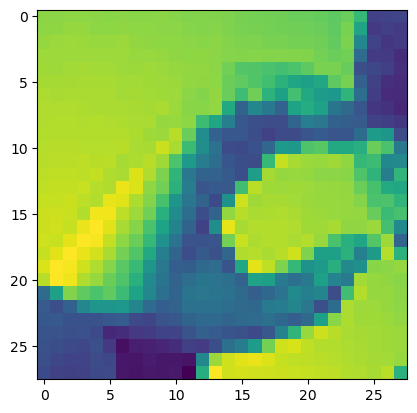

In [29]:
plt.imshow(X_train2[3])

0.0


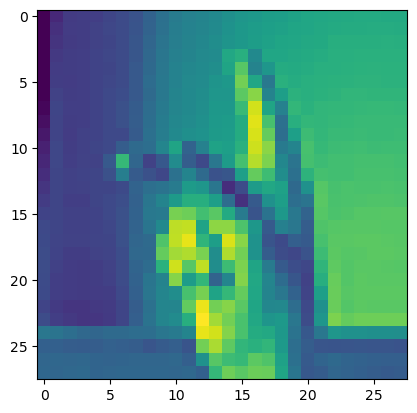

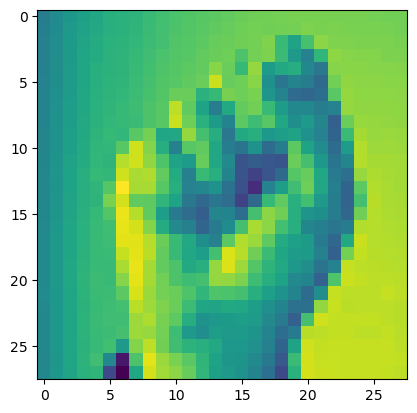

In [30]:
data=pd.read_csv('sign_mnist_train.csv')
l1=[]
l2=[]
l3=[]
for i in data['label'].unique():
    l1.append(data[data['label']==i].head(1).drop('label',axis=1).values)
    l2.append(data[data['label']==i].tail(8).drop('label',axis=1).values)
    l3.append(data[data['label']==i].head(10).tail(9).drop('label',axis=1).values)
from itertools import combinations
com=list(combinations(range(7), 2))
same=[]
for j in range(len(l2)):  # iterate through indices instead of arrays
    ooo=[]
    for i in com:
        ooo.append([l2[j][i[0]],l2[j][i[1]]])
    same.append(ooo)
ss=[]
for i in range(len(same)):
    for j in range(len(same[i])):
        ss.append(same[i][j])
dif=[]
for i in range(24):
    for j in range(24):
        if i!=j:
            dif.append([l1[i][0],l2[j][0]])
same=ss
np.array(same).shape
np.array(dif).shape
X1=[]
for i in same:
    X1.append(i[0])
for i in dif:
    X1.append(i[0])
X2=[]
for i in same:
    X2.append(i[1])
for i in dif:
    X2.append(i[1])
len(X1)
y1=np.ones(len(same))
y2=np.zeros(len(dif))
y=np.concatenate([y1,y2])
import random
ind=list(range(len(y)))
random.shuffle(ind)
X2_new=np.array(X2)[ind]
X1_new=np.array(X1)[ind]
y_new=y[ind]
from sklearn.model_selection import train_test_split
X1_train, X_1_test, y_train, y_test = train_test_split(X1_new, y_new, test_size=0.2, random_state=42)
X2_train, X_2_test, y_train, y_test = train_test_split(X2_new, y_new, test_size=0.2, random_state=42)
ii=5
print(y_train[ii])
plt.imshow(X1_train[ii].reshape(28,28))
plt.show()
plt.imshow(X2_train[ii].reshape(28,28))
plt.show()

In [1131]:
X1_train

array([[152, 155, 158, ..., 162, 144, 135],
       [114,  42,  74, ..., 227, 228, 228],
       [107, 118, 127, ..., 204, 203, 202],
       ...,
       [131, 135, 139, ..., 191, 190, 191],
       [221, 221, 222, ..., 233, 233, 232],
       [ 94,  96, 101, ..., 168, 168, 167]])

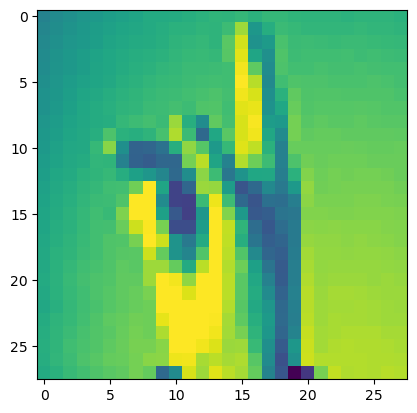

In [1174]:
plt.imshow(X1_train[cac1:cac2].reshape(28,28))

In [31]:

(c1,p1)=cnn.forward(X1_train[:100].reshape(-1,28,28,1))
(c2,p2)=cnn.forward(X2_train[:100].reshape(-1,28,28,1))
emb1=c1[-1][0].reshape(-1,1024)
emb2=c2[-1][0].reshape(-1,1024)


In [32]:
losl=[]
acacs=[]
for i in range(1000):
    emm1=linear_forward(emb1/255,te['W1'],te['b1'])
    emm2=linear_forward(emb2/255,te['W1'],te['b1'])
    grad1,grad2=contrastive_loss_backward(emm1[0],emm2[0],y_train[:100])
    pred_=predict_siamese(emm1[0],emm2[0],5)
    lo=contrastive_loss(emm1[0],emm2[0],y_train[:100])
    acc=ac(pred_[0],y_train[:100])
    losl.append(lo)
    acacs.append(acc)
    print(i,lo,acc)
    gra1=linear_backward(grad1,emm1[1])
    gra2=linear_backward(grad2,emm2[1])
    te=update_param(te,gra1,gra2,0.0001)



0 101.9476958747756 0.48
1 95.90320844384613 0.48
2 90.45027951774817 0.48
3 85.51774841245155 0.48
4 81.0438295554749 0.48
5 76.97482426587877 0.48
6 73.26401328565785 0.48
7 69.8707044169492 0.48
8 66.75941328106472 0.48
9 63.89915835223645 0.48
10 61.26285410648538 0.48
11 58.826788428713215 0.48
12 56.57017239421157 0.48
13 54.47475223159252 0.48
14 52.5244747231606 0.48
15 50.70519854065895 0.48
16 49.00444507882361 0.48
17 47.41118326170106 0.48
18 45.91564357900474 0.48
19 44.5091572805542 0.48
20 43.18401723203024 0.48
21 41.93335742856858 0.48
22 40.75104858582205 0.48
23 39.63160759108038 0.48
24 38.57011890844499 0.48
25 37.562166299277635 0.48
26 36.60377344848313 0.48
27 35.691352284053565 0.48
28 34.82165794632411 0.48
29 33.991749508535605 0.48
30 33.19895567496686 0.48
31 32.44084479000358 0.48
32 31.715198583545867 0.48
33 31.01998915726516 0.48
34 30.35335878423633 0.48
35 29.7136021529637 0.48
36 29.09915073714239 0.48
37 28.508559015799094 0.48
38 27.940492305736047

KeyboardInterrupt: 

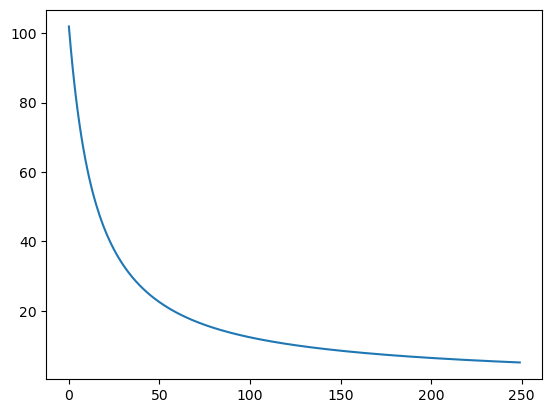

In [42]:
plt.plot(losl[:250])

In [1310]:
pred_=predict_siamese(emm1[0],emm2[0],6)
print(ac(pred_[0],y_test))
pred_

0.8915094339622641


(array([[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
         0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
         0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
         1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
         1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
         1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]], dtype=int32),
 array([[ 5.94779549,  4.87252471,  5.79578945,  7.39285211,  5.02802516,
          5.73868997,  6.21315762,  5.70759655,  5.49834631,  5.54430324,
          8.18090485, 11.32946853,  5.90710501, 11.46955688,  5.07130278,
          7.36252476,  7.88490366,  

In [1189]:
lol=[]
for i in data['label'].unique():
    lol.append(data[data['label']==i].head(1).tail(1).drop('label',axis=1).values)
lab=np.array(lol).reshape(-1,784)
l3=[]

for i in data['label'].unique():
    l3.append(data[data['label']==i].head(912).tail(24).drop('label',axis=1).values)
    
testmore=np.array(l3)


In [1190]:
testmore[0].shape

(24, 784)

In [1210]:
dm=np.array([testmore[1][8] for i in range(24)]).reshape(-1,784)

In [1300]:
(c1,p1)=cnn.forward(testmore[2].reshape(-1,28,28,1)/255)
(c2,p2)=cnn.forward(lab.reshape(-1,28,28,1)/255)
emb1=c1[-1][0].reshape(-1,1024)
emb2=c2[-1][0].reshape(-1,1024)
emm1=linear_forward(emb1,te['W1'],te['b1'])
emm2=linear_forward(emb2,te['W1'],te['b1'])


In [1301]:
pred_=predict_siamese(emm1[0],emm2[0],6)
pred_

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], dtype=int32),
 array([[ 8.34783574, 11.43726172,  8.47139584,  8.74397723, 14.11454312,
          7.3594729 , 10.38549622, 12.83449031, 14.65752269,  8.20735713,
          7.76535748,  8.40643929,  9.97874672, 10.56730194, 12.95025774,
          7.87596024, 10.78332003,  8.65304629, 11.78642043, 11.19126789,
          8.0456285 ,  9.19685831,  8.00765197,  7.80635828]]))

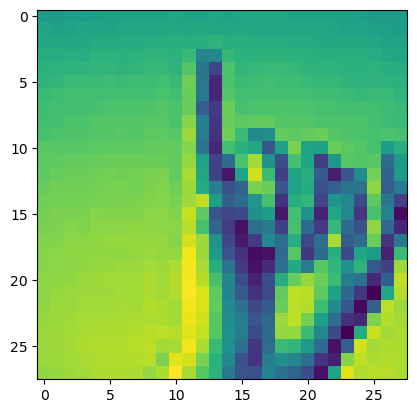

In [1302]:
plt.imshow(lab[np.argmin(pred_[1])].reshape(28,28))

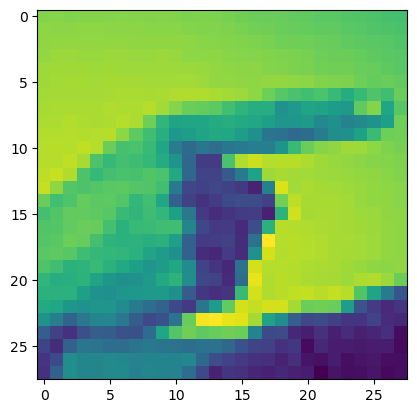

In [1303]:
plt.imshow(testmore[1][8].reshape(28,28))

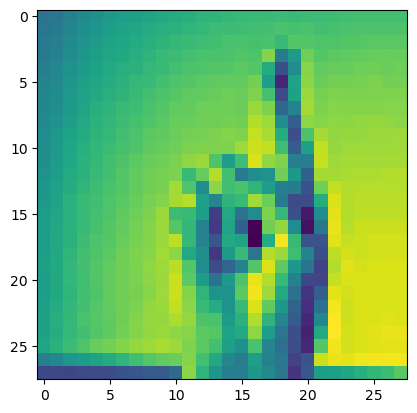

In [34]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Khởi tạo Mediapipe Hands
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
dic = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q',
    16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'
}

cap = cv2.VideoCapture(0)
c=0
pred_label=0
predicted_char = dic.get(pred_label, "?")
with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                h, w, _ = frame.shape
                x_min, y_min = w, h
                x_max, y_max = 0, 0
                h, w, _ = frame.shape
                x_min, y_min = w, h
                x_max, y_max = 0, 0
                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * w), int(landmark.y * h)
                    x_min, y_min = min(x, x_min), min(y, y_min)
                    x_max, y_max = max(x, x_max), max(y, y_max)
                # Tính kích thước lớn nhất để làm hình vuông
                box_size = max(x_max - x_min, y_max - y_min)+ 30
                x_center = (x_min + x_max) // 2
                y_center = (y_min + y_max) // 2
                x_min = max(0, x_center - box_size // 2)
                y_min = max(0, y_center - box_size // 2)
                x_max = min(w, x_center + box_size // 2)
                y_max = min(h, y_center + box_size // 2)
                # Crop bàn tay từ ảnh gốc
                hand_img = frame[y_min:y_max, x_min:x_max]
                # Chuyển sang ảnh grayscale
                hand_gray = cv2.cvtColor(hand_img, cv2.COLOR_BGR2GRAY)
                # Resize về 28x28 (chuẩn cho CNN)
                hand_resized = cv2.resize(hand_gray, (28, 28))
                # Chuẩn hóa ảnh về [0,1]
                hand_normalized = (hand_resized - np.min(hand_resized)) / (np.max(hand_resized) - np.min(hand_resized))
                hand_reshaped = hand_normalized.reshape(28, 28, 1)
                
                if c==5:
                    pred_label = pred(np.array([hand_reshaped]), cnn)[0]

                    # Lấy ký tự ASL tương ứng
                    predicted_char = dic.get(pred_label, "?")
                    # Vẽ bounding box hình vuông
                    c=0
                    
                c+=1
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                    # Hiển thị nhãn dự đoán trên bounding box
                cv2.putText(frame, f"{predicted_char}", (x_min, y_min - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Hiển thị kết quả trên webcam
        cv2.imshow("ASL Hand Recognition", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
plt.close()


libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: 